In [1]:
# Install TensorFlow
!pip install -q tensorflow numpy matplotlib

In [2]:
# Imports
import os
import sys
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, Add, Dropout, Input, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Add
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, HTML
from PIL import Image
import pickle
import requests
from io import BytesIO

In [3]:
# Download a preprocessed subset of COCO (images and captions)
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!unzip -q Flickr8k_Dataset.zip
!unzip -q Flickr8k_text.zip

In [4]:
# Function to open and read the contents of a file
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Function to create a dictionary mapping image IDs to lists of captions
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

# Load and process the document containing image IDs and captions
doc = load_doc('/content/Flickr8k.token.txt')
descriptions = load_descriptions(doc)
print(f'loaded {len(descriptions)} descriptions')


# Function to load, resize, and preprocess an image for InceptionV3 model
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


loaded 8092 descriptions


In [5]:
# Load the InceptionV3 model with pre-trained ImageNet weights
# And create a new model by taking the input from inception and output from the second-to-last layer
inception = InceptionV3(weights='imagenet')
model_new = Model(inception.input, inception.layers[-2].output)

# Function to encode an image into a feature vector using InceptionV3
def encode_image(img):
     # Preprocess the image to match InceptionV3 input requirements
    img = preprocess_image(img)
    # Extract the feature vector from the image
    feature = model_new(tf.expand_dims(img, axis=0))
    # Reshape the feature vector to match the expected input shape
    return tf.reshape(feature, (-1,))


96112376/96112376 [==============================] - 3s 0us/step


In [6]:
# Initialize tokenizer with a specified vocabulary size and token for out-of-vocabulary words
# Flatten all captions into a single list for the tokenizer
# # Fit the tokenizer on all captions to create a vocabulary
# Calculate the total vocabulary size
tokenizer = Tokenizer(num_words=10000, oov_token="<unk>")
all_captions = [cap for caps_list in descriptions.values() for cap in caps_list]
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Generator function to yield batches of data for model training
def data_generator(descriptions, tokenizer, max_length):
    while 1:
        # Iterate through each image and its list of descriptions
        for key, desc_list in descriptions.items():
            photo_path = '/content/Flicker8k_Dataset/' + key + '.jpg'
            if not os.path.exists(photo_path):
                continue
            photo = encode_image(photo_path)
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, desc_list, photo)
            yield [[input_image, input_sequence], output_word]

# Function to create input and output sequences for training from captions
def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)


In [7]:
# Define the CNN-RNN model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = Add()([fe2, se3])  # Change 'add' to 'Add()' here
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

# Train the model
model = define_model(vocab_size, max_length=34)
steps = len(descriptions)
generator = data_generator(descriptions, tokenizer, max_length=34)
model.fit_generator(generator, epochs=5, steps_per_epoch=steps, verbose=1)


<ipython-input-7-94d73da859cb>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=5, steps_per_epoch=steps, verbose=1)


Epoch 1/5
8092/8092 [==============================] - 1445s 178ms/step - loss: 4.3342
Epoch 2/5
8092/8092 [==============================] - 1419s 175ms/step - loss: 3.5450
Epoch 3/5
8092/8092 [==============================] - 1436s 178ms/step - loss: 3.3035
Epoch 4/5
8092/8092 [==============================] - 1429s 177ms/step - loss: 3.1656
Epoch 5/5
8092/8092 [==============================] - 1451s 179ms/step - loss: 3.0764


In [35]:
# Save the model
model.save('/content/image_captioning_model.h5')

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
def encode_image_prediction(img_path):
    img = preprocess_image(img_path)
    img = tf.expand_dims(img, axis=0)
    feature = model_new.predict(img)
    return feature.reshape(-1,)

# Function to convert an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to convert an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate caption for a new image
def generate_caption(image_features, tokenizer):
    # Start captioning process
    in_text = '<start>'
    for i in range(max_length):
        # Tokenize input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad input sequence
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict next word
        yhat = saved_model.predict([np.array([image_features]), np.array(sequence)], verbose=0)
        # Convert probability to word
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        # Break if end of sequence is predicted
        if word is None or word == '<end>':
            break
        # Append as input for generating the next word
        in_text += ' ' + word
    return in_text

In [ ]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the saved model
saved_model = load_model('/content/image_captioning_model.h5')

# Load the saved tokenizer
with open('/content/tokenizer.pkl', 'rb') as f:
    saved_tokenizer = pickle.load(f)

In [ ]:
# Define the maximum length of input sequence
max_length = 34

# Predict the model (Example-1):
image_path = '/content/Flicker8k_Dataset/1028205764_7e8df9a2ea.jpg'
image = preprocess_image(image_path)
image_features = encode_image_prediction(image_path)
caption = generate_caption(image_features, saved_tokenizer)

# Display the image
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Display the caption
display(HTML(f'<p>Generated Caption: {caption}</p>'))

1/1 [==============================] - 0s 27ms/step


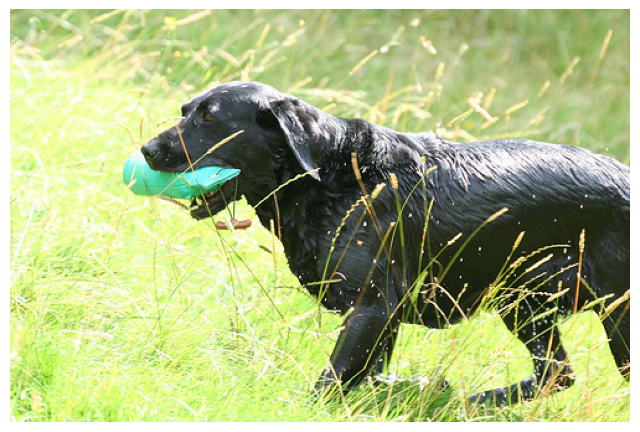

In [38]:
# Predict the model (Example-2):
image_path = '/content/Flicker8k_Dataset/1026685415_0431cbf574.jpg'
image = preprocess_image(image_path)
image_features = encode_image_prediction(image_path)
caption = generate_caption(image_features, saved_tokenizer)

# Display the image
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Display the caption
display(HTML(f'<p>Generated Caption: {caption}</p>'))

1/1 [==============================] - 0s 25ms/step


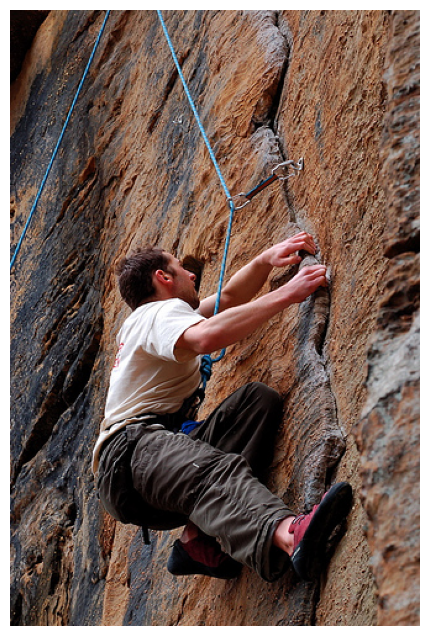

In [40]:
# Predict the model (Example-2):
image_path = '/content/Flicker8k_Dataset/111537217_082a4ba060.jpg'
image = preprocess_image(image_path)
image_features = encode_image_prediction(image_path)
caption = generate_caption(image_features, saved_tokenizer)

# Display the image
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Display the caption
display(HTML(f'<p>Generated Caption: {caption}</p>'))